<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/multivariate_pendigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 798.78 KiB | 19.97 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [5]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [6]:
RANDOM_STATE = 39
X,y,data_information = load_dataset('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [7]:
# Upsample the minority class
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [8]:
X_train = X_train.transpose (0,2,1)
X_test = X_test.transpose(0,2,1)
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


y = 9


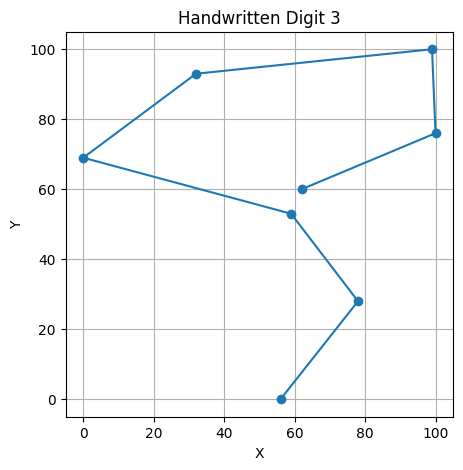

In [9]:
visualise_digit(X_train,y_train,9100)

In [10]:
X_train, y_train, X_test, y_test= extract_two_digits(X_train_processed_padded,y_train,X_test_processed_padded,y_test,'0','8',RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]


y = 0


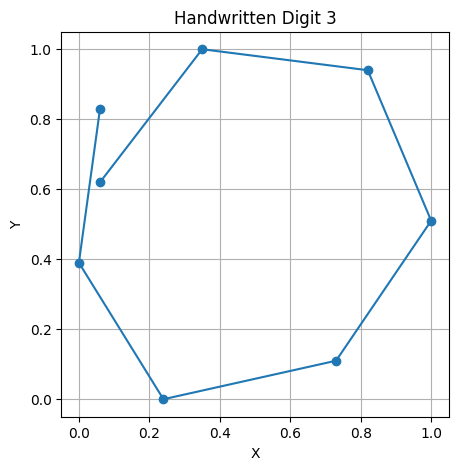

In [11]:
visualise_digit(X_train,y_train,100)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


In [13]:
print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


y = 0


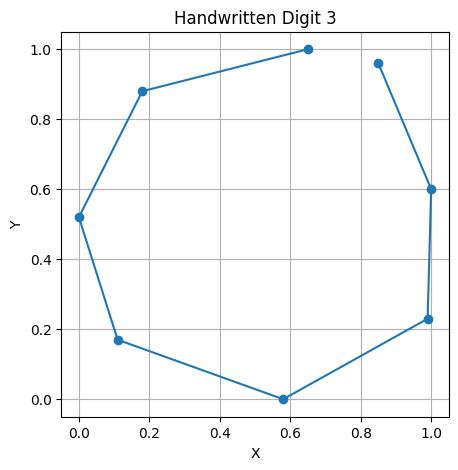

In [14]:
visualise_digit(X_train,y_train_classes,100)

In [15]:


# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 17s 21ms/step - loss: 0.2667 - accuracy: 0.9351 - val_loss: 0.5366 - val_accuracy: 0.9672
Epoch 2/150
122/122 [==============================] - 1s 11ms/step - loss: 0.1068 - accuracy: 0.9843 - val_loss: 0.3415 - val_accuracy: 0.9809
Epoch 3/150
122/122 [==============================] - 1s 9ms/step - loss: 0.0813 - accuracy: 0.9945 - val_loss: 0.1931 - val_accuracy: 0.9973
Epoch 4/150
122/122 [==============================] - 1s 8ms/step - loss: 0.0698 - accuracy: 0.9952 - val_loss: 0.0992 - val_accuracy: 0.9973
Epoch 5/150
122/122 [==============================] - 1s 9ms/step - loss: 0.0625 - accuracy: 0.9959 - val_loss: 0.0692 - val_accuracy: 0.9973
Epoch 6/150
122/122 [==============================] - 1s 8ms/step - loss: 0.0542 - accuracy: 0.9986 - val_loss: 0.0574 - val_accuracy: 0.9973
Epoch 7/150
122/122 [==============================] - 1s 7ms/step - loss: 0.0500 - accuracy: 1.0000 

In [16]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features,32)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 8, 2)
(None, 8, 32)
(None, 4, 32)
(None, 4, 16)
(None, 2, 16)
(None, 2, 16)
(None, 4, 16)
(None, 4, 32)
(None, 8, 32)
(None, 8, 2)
Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 3s - loss: 0.1447 - val_loss: 0.0482 - 3s/epoch - 26ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0321 - val_loss: 0.0222 - 592ms/epoch - 5ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0143 - 539ms/epoch - 4ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0123 - val_loss: 0.0104 - 534ms/epoch - 4ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0091 - val_loss: 0.0080 - 561ms/epoch - 5ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0075 - val_loss: 0.0065 - 515ms/epoch - 4ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0063 - val_loss: 0.0058 - 542ms/epoch - 4ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0055 - val_loss: 0.0050 - 645ms/epoch - 5ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0049 - val_loss: 0.0048 - 787ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0045 - val_loss: 0.0043 - 698ms/epoch - 6ms/st

1/1 [==============================] - 0s 202ms/step
y = [[0. 1.]]


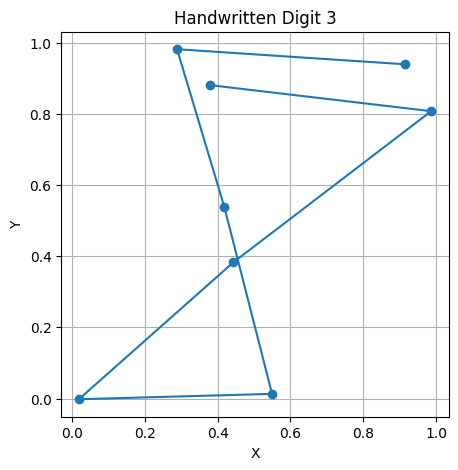

y = [0. 1.]


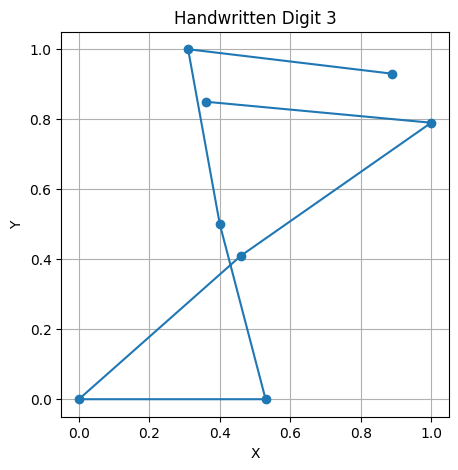

In [17]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [18]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate
w_type = "global"
pos_label = 1
neg_label = 0

if w_type == "global":
    step_weights = get_global_weights(
        X_train,
        y_train_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test[y_pred_classes == neg_label][20:30]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][10:20]
    lr_list = [0.001]


46/46 [==============================] - 0s 3ms/step
The current prediction margin weight is 1.


In [19]:
step_weights

array([[[1., 1.],
        [1., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 1.],
        [1., 1.]]])

In [28]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5,tolerance=1e-6, max_iter=100, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),autoencoder = autoencoder,
    pred_margin_weight=1, step_weights = step_weights, random_state= RANDOM_STATE)
cf_model.fit(cnnClassifier)

y_neg = y_train_classes[y_train_classes == 0][0:5]
X_neg = X_train[y_train_classes == 0][0:5]


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses, weights = cf_model.transform(X_neg, y_neg) #self, x, pred_label
z_pred = cnnClassifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs

#evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
#evaluate_res #  proximity, validity, cost_mean, cost_std

1 samples been transformed.
5 samples been transformed, in total.
1/1 [==============================] - 0s 81ms/step


actual
y = 0


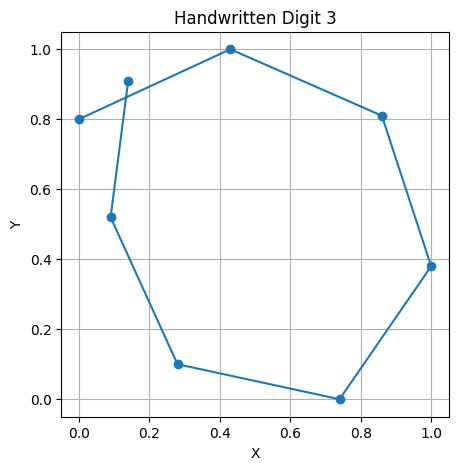

counterfactual
y = 0


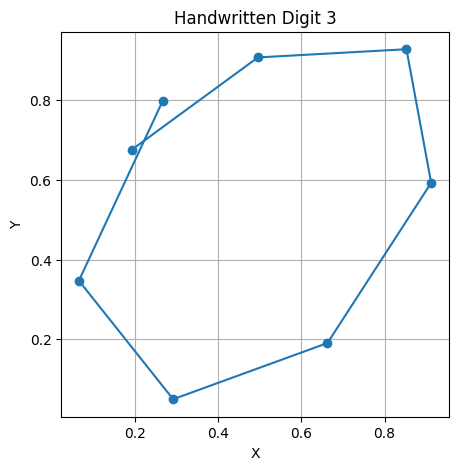

actual
y = 0


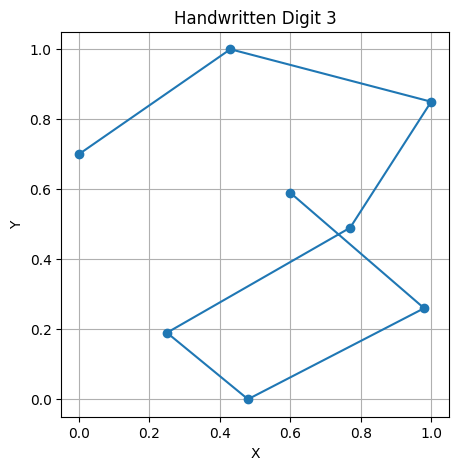

counterfactual
y = 0


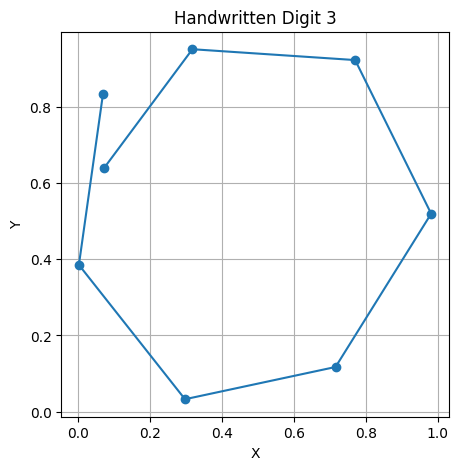

actual
y = 0


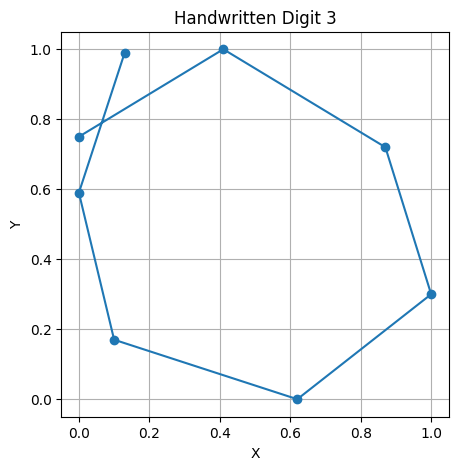

counterfactual
y = 0


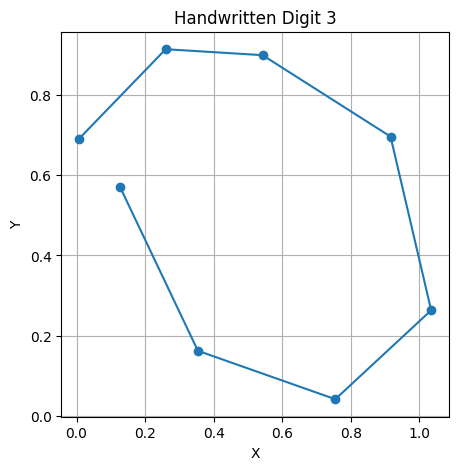

actual
y = 0


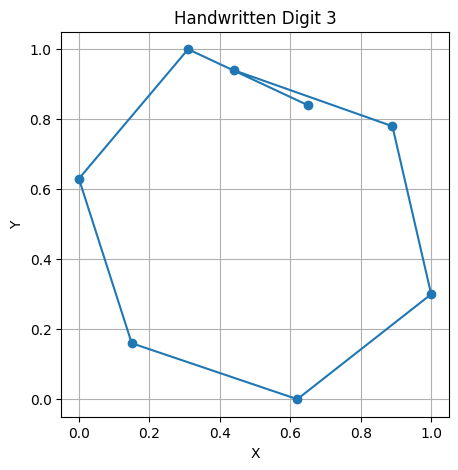

counterfactual
y = 0


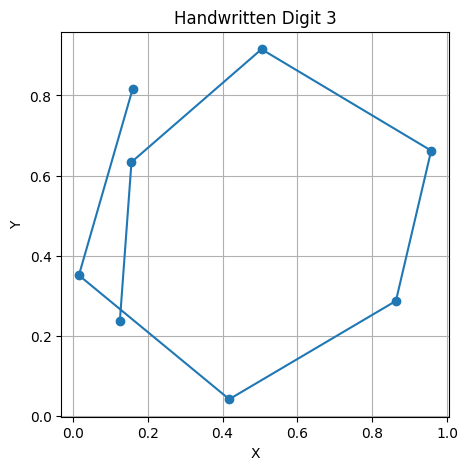

actual
y = 0


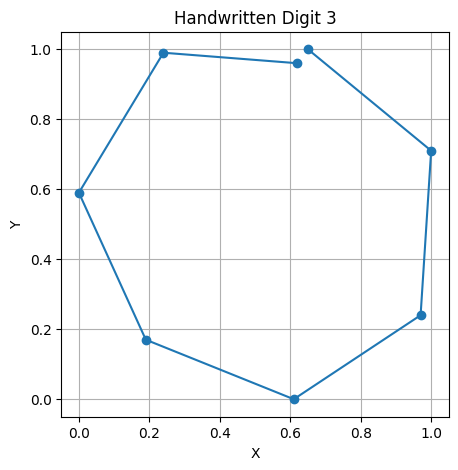

counterfactual
y = 0


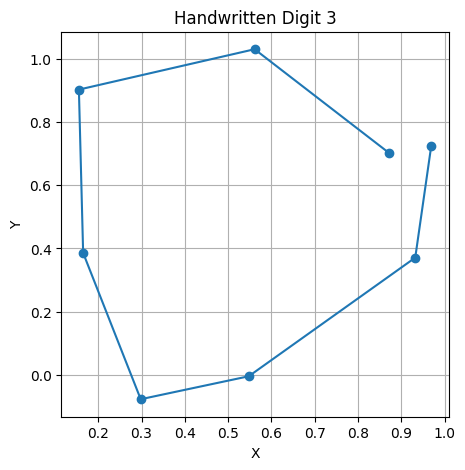

actual
y = 0


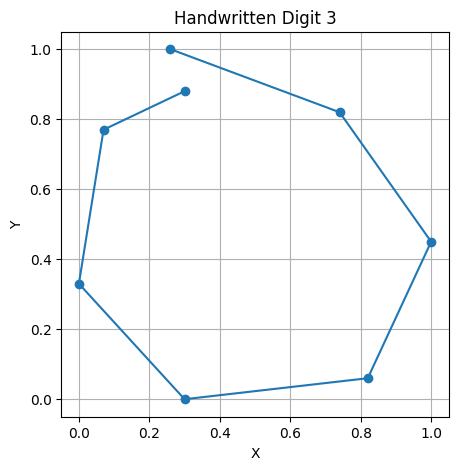

counterfactual
y = 0


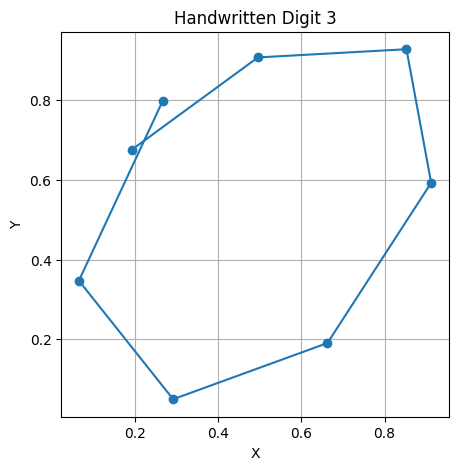

actual
y = 0


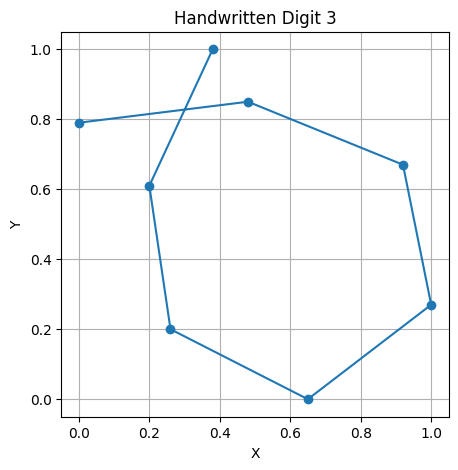

counterfactual


IndexError: ignored

In [29]:
for i in range(11):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i-1,figsize = (5,5))
